In [50]:
# 3L_SDVRP 


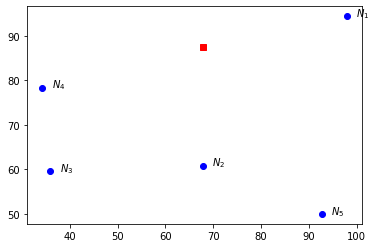

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from scipy.stats import dirichlet
from py3dbp import Packer, Bin, Item


# "rnd" is an object that generate random numbers
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers
rnd.seed(0)
# Number of collection points
n_customer = 5
# The set of nodes without the depot.
N = [i for i in range(1,n_customer+1)]
# The set of nodes + the depot.
V = [0]+ N
# The Number of cargoes
Cat = 10
# Generating items for each collection point
IT = []
for i in N:
    cargo_set_=[]
    for j in range (0,Cat):
        cargo_set_.append({(i,j):[rnd.randint(1, kk) for kk in [10,10,10,100]]})
    IT.append(cargo_set_)
# Number of Vehicles
nv = 3
# Max volume and Max weight that each vehicle can carry
Container_vehicle = [('vehicle_%d'%kk, rnd.randint(50, 100), rnd.randint(50, 100), rnd.randint(50, 100), rnd.randint(100, 500)) for kk in range(0,nv) ]
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n_customer+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n_customer+1)*100
# The number of Routing plans
RP = 10
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$N_%d$'%(i),(xc[i]+2,yc[i]))
# Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
# Showing the Initial plot.
plt.show()
# Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
# Calculating the distance between each node as non-negative cost of each arc
dist= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
# Generating historical data wich show how many times each route has been chosen
historical_routes = [rnd.randint(1, 100) for i in range(0, len(A))]

In [ ]:
import dirichlet
help(dirichlet)
dirichlet.meanprecision(np.array(historical_routes))
dirichlet.mle(np.array(10,5), tol=1e-07, method='meanprecision', maxiter=None)

In [54]:
# Vehicle Route Planning Module

# alpha = np.array(historical_routes) # alpha is an array of our historical data for each edge

def findRoutPlans(alpha):
    drichlet_mean = dirichlet.mean(alpha)
    multinomial_ed = multinomial.rvs(300, drichlet_mean, size=RP*2)
    # Finding Edges
    semi_final_path = []
    for routplansiterator in range(0, len(multinomial_ed)):
        sorted_edges=[]
        for maxifinder in range(max(multinomial_ed[routplansiterator]), -1, -1):
            finded = np.where(multinomial_ed[routplansiterator] == maxifinder)
            sorted_edges.append(finded[0])
        first_path = []
        for hh in sorted_edges:
            for ff in hh:
                # Checking for duplicate collection points
                if len(first_path)>0:
                    first_elements = [i for i,j in first_path]
                    second_elements = [j for i,j in first_path]
                    if A[ff][0] not in first_elements and A[ff][1] not in second_elements:
                        first_path.append(A[ff])
                else:
                    first_path.append(A[ff])
        semi_final_path.append(first_path[0:n_customer])
    
    # Removing invalids
    numfailed = []
    for rpiterator in range(0,len(semi_final_path)):
        starting_point=0
        for jkl in semi_final_path[rpiterator]:
            starting_point=starting_point+1
            for lkj in semi_final_path[rpiterator][starting_point:]:
                if (jkl[1] == lkj[0] and jkl[0] == lkj[1]):
                    numfailed.append(rpiterator)
                    
    final_path = [i for n, i in enumerate(semi_final_path) if n not in numfailed]
    return final_path


In [55]:
# Collection points that vehicle should pass

def collectionPointsFinder(final_path):
    allocatedCPs=[]
    CPs=[]
    for y in range(0,len(final_path)):
        for i, j in final_path[y]:
            CPs.append(i)
            CPs.append(j)
        allocatedCPs.append(set(myset))
    return allocatedCPs


In [56]:
# Splitting Module

# Sorting
def splitCargoes(alpha_s):
    drichlet_mean_s = dirichlet.mean(alpha_s)

    multinomial_ed_s = multinomial.rvs(100, drichlet_mean_s, size=5)

    # Choosing Cargoes
    final_set = []
    for cargoewclassiterator in range(0, len(multinomial_ed_s)):
        sorted_cargoes=[]
        for maxfinder in range(max(multinomial_ed_s[cargoewclassiterator]), -1, -1):
            if maxfinder>0:
                finded_cargoes = np.where(multinomial_ed_s[cargoewclassiterator] == maxfinder)
                sorted_cargoes.append(finded_cargoes[0])
        first_set = []
        for hh in sorted_cargoes:
            for ff in hh:
                first_set.append(IT[cargoewclassiterator][ff])
        final_set.append([first_set])

    return final_set

In [57]:
# split between vehicles

alpha = np.array(historical_routes)
final_path = findRoutPlans(alpha)

one_prob = [1 for i in range(0, len(IT[0]))]
alpha_s = np.array(one_prob)
final_set = splitCargoes(alpha_s)

# Cargoes for vehicles

set_for_vehicles=[]
for vehicle_num in range(0,nv):
    init_set=[]
    for custom_num in range(0,n_customer):
        init_set.append(final_set[custom_num][0][vehicle_num*round(Cat/nv):vehicle_num*round(Cat/nv)+round(Cat/nv)])
    set_for_vehicles.append(init_set)
set_for_vehicles[0]


[[{(1, 3): [2, 7, 8, 88]}, {(1, 8): [4, 4, 8, 33]}, {(1, 2): [8, 7, 9, 89]}],
 [{(2, 2): [6, 6, 7, 18]}, {(2, 6): [5, 5, 7, 69]}, {(2, 3): [5, 9, 2, 66]}],
 [{(3, 2): [5, 3, 1, 94]}, {(3, 3): [4, 3, 1, 22]}, {(3, 4): [1, 3, 8, 60]}],
 [{(4, 8): [5, 7, 6, 32]}, {(4, 9): [8, 9, 9, 80]}, {(4, 0): [7, 4, 4, 57]}],
 [{(5, 9): [8, 8, 4, 47]}, {(5, 1): [7, 2, 7, 45]}, {(5, 2): [9, 9, 4, 83]}]]

In [78]:
# Optimal 3D Loading Module

def loading(Container_vehicle, final_set):
    packer = Packer()

    # The maximum volum and weight that a container can carry (length, width, height, weight)
    vehicle_count = 0
    for vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight in Container_vehicle:
        # Add bins Number of vehicles
        vehicle_count = vehicle_count + 1
        packer.add_bin(Bin(vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight)) 
        

    for customeritems in final_set:
        for items in customeritems:
            for boxes in items:
                packer.add_item(Item(list(boxes.keys())[0],
                                    list(boxes.values())[0][0],
                                    list(boxes.values())[0][1],
                                    list(boxes.values())[0][2],
                                    list(boxes.values())[0][3]))
    packer.pack(number_of_decimals=0)
    for b in packer.bins:
        print(":::::::::::", b.string())

        print("FITTED ITEMS:")
        for item in b.items:
            print("====> ", item.string())

        print("UNFITTED ITEMS:")
        for item in b.unfitted_items:
            print("====> ", item.string())

        print("**************************")

    return packer



In [79]:
pc = loading(Container_vehicle, final_set)

::::::::::: vehicle_1(59x60x77, max_weight:299) vol(272580)
FITTED ITEMS:
====>  (2, 1)(3x1x1, weight: 37) pos([0, 0, 0]) rt(0) vol(3)
====>  (3, 9)(1x1x7, weight: 1) pos([Decimal('3'), 0, 0]) rt(0) vol(7)
====>  (1, 9)(2x1x5, weight: 24) pos([Decimal('4'), 0, 0]) rt(0) vol(10)
====>  (2, 5)(3x1x4, weight: 54) pos([Decimal('6'), 0, 0]) rt(0) vol(12)
====>  (3, 3)(4x3x1, weight: 22) pos([Decimal('9'), 0, 0]) rt(0) vol(12)
====>  (3, 7)(2x3x2, weight: 37) pos([Decimal('9'), 0, Decimal('1')]) rt(0) vol(12)
====>  (3, 1)(6x1x2, weight: 51) pos([Decimal('9'), 0, Decimal('1')]) rt(0) vol(12)
====>  (4, 4)(4x1x5, weight: 68) pos([Decimal('9'), 0, Decimal('1')]) rt(0) vol(20)
====>  (4, 1)(9x9x3, weight: 4) pos([Decimal('13'), 0, 0]) rt(0) vol(243)
UNFITTED ITEMS:
====>  (3, 2)(5x3x1, weight: 94) pos([Decimal('9'), 0, Decimal('1')]) rt(0) vol(15)
====>  (1, 0)(6x1x4, weight: 68) pos([Decimal('9'), 0, Decimal('1')]) rt(0) vol(24)
====>  (1, 6)(4x6x1, weight: 83) pos([Decimal('9'), 0, Decimal('1

In [589]:
# Init Population for NSGA_II

alpha = np.array(historical_routes)

one_prob = [1 for i in range(0, len(IT[0]))]
alpha_s = np.array(one_prob)

init_pop_route = []
init_pop_set = []
init_pop_pack = []

for ind in range(0,100):
    fr = findRoutPlans(alpha)
    sp = splitCargoes(alpha_s)
    pc = loading(Container_vehicle, sp)
    init_pop_route.append(fp[0:3])
    init_pop_set.append(sp)
    init_pop_pack.append(pc)


In [590]:
# Fitness Function 1

F1=[]
for pop in akjdsd:
    F1_init=[]
    for vehicles in range(0, len(pop)):
        route_cost = 0
        for i in pop[vehicles]:
            route_cost = route_cost + dist[i]
        F1_init.append(route_cost)
    F1.append(sum(F1_init))
F1

[516.7397157466168,
 532.3861298922463,
 587.5920752418383,
 558.2775440678323,
 523.72028688294,
 575.3309649686057,
 541.1783440721626,
 539.7114062498231,
 570.9377265484179,
 571.5472196654962]

In [168]:
# Fitness Function 2

containers_weight = [each[4] for each in Container_vehicle]
containers_volume = [each[1]*each[2]*each[3] for each in Container_vehicle]


total_items_weight = [item.weight for item in pc.items]
total_items_volume = [item.get_volume() for item in pc.items]

rvol_mean = sum(items_volume)/sum(containers_volume)
rwgh_mean = sum(items_weight)/sum(containers_weight)

fitted_items_weight = [item.weight for item in pc.bins[0].items]
fitted_items_volume = [item.get_volume() for item in pc.bins[0].items]



In [169]:
# LP minimization module

from mip import CBC
from mip import Model, xsum, minimize, BINARY, maximize
Sload = 10
Qload = 10
s = [6, 2, 3, 4, 10, 4]
q = [10, 5, 6, 1, 8, 8]
A = len(q)
model = Model(sense = maximize, solver_name = CBC)
p = [model.add_var() for k in range(0, A)]
model.objective = maximize(xsum((s[k] + q[k]) * p[k] for k in range(0, A)))

model += xsum(s[k] * p[k] for k in range(0, A)) <=Sload
model += xsum(q[k] * p[k] for k in range(0, A)) <=Qload
for k in range(0, A):
    model += p[k] <=1
model.optimize(max_seconds = 300)
status = model.optimize()
print(status)
for k in range(0, A):
    print(p[k].x)
